# Support Vector Machines (SVM) Model Train

In [ ]:
import pandas as pd
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'O', 'P', 'Q', 'R', 'U', 'V', 'W', 'X', 'Y']
class_names_labels = {j:i for i,j in enumerate(class_names)}
print(class_names_labels)
IMAGE_SIZE = (256,256)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'O': 11, 'P': 12, 'Q': 13, 'R': 14, 'U': 15, 'V': 16, 'W': 17, 'X': 18, 'Y': 19}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data transform
Retrieve dataset from google drive and transfrom it.

To convert images to grayscale and remove noise.

In [ ]:
# Remove noise function
import cv2
def remove_noise(image):
    denoised_image = cv2.fastNlMeansDenoising(np.array(image), None, h=10, templateWindowSize=7, searchWindowSize=21)
    return Image.fromarray(denoised_image)

In [ ]:
def load_data():
  images = []
  labels = []
  path = '/content/drive/MyDrive/Machine Learning Lab/Project/Project_dataset/crop'

  for folder in os.listdir(path):
    label = class_names_labels[folder]

    for file in os.listdir(os.path.join(path, folder)):
      if file[-3:] in {'jpg', 'png'}:
        img_path = os.path.join(path, folder, file)
        img = Image.open(img_path)
        img = img.convert('L')      # Images turn grayscale
        img = img.resize(IMAGE_SIZE)# Resize to 256, 256
        img = remove_noise(img)     # Remove noise
        images.append(img)
        labels.append(label)
  images = np.array([np.array(i) for i in images])
  labels = np.array([np.array(i) for i in labels])
  return images, labels
x,y = load_data()

In [ ]:
x = np.array(x)
y = np.array(y)
print(x.shape, y.shape)

(2400, 256, 256) (2400,)


#Some Samples Images


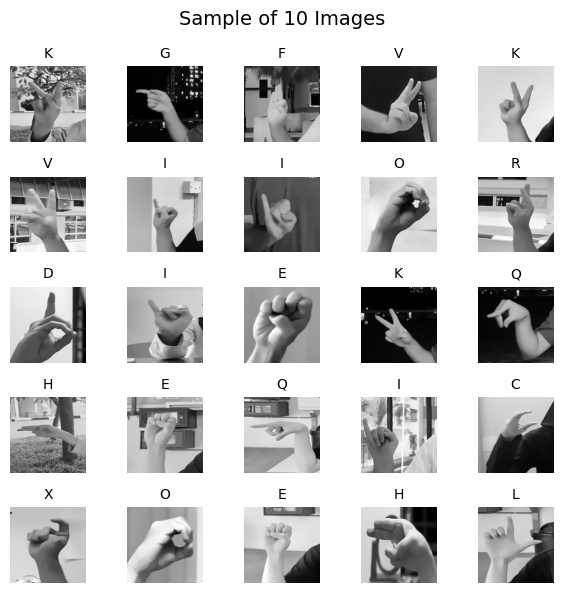

In [ ]:
# Randomly select 10 images
indices = np.random.choice(len(x), size=25, replace=False)
sample_images = x[indices]
sample_labels = y[indices]

# Create a figure with a grid layout
fig, axes = plt.subplots(5, 5, figsize=(6, 6))
fig.suptitle('Sample of 10 Images', fontsize=14)

# Iterate over the sample images and their class labels
for i in range(25):
    # Get the image and its corresponding class label
    image = sample_images[i]
    label = sample_labels[i]
    class_name = class_names[label]

    # Plot the image and write the class name at the top
    ax = axes[i // 5, i % 5]
    ax.imshow(image, cmap='gray')
    ax.set_title(class_name, fontsize=10)
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()

# Split dataset to train and test

60% Training, 20% Testing, 20% Validation

In [ ]:
# Split 60% Training set, 20% Validation set and 20% testing set
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=0)
print(x_train.shape, x_test.shape, x_val.shape)

(1440, 256, 256) (480, 256, 256) (480, 256, 256)


# Reshape into 1 D

In [ ]:
# Reshape images
x_train_flat = x_train.reshape(-1, x_train.shape[1] * x_train.shape[2])
x_val_flat = x_val.reshape(-1, x_val.shape[1] * x_val.shape[2])
x_test_flat = x_test.reshape(-1, x_test.shape[1] * x_test.shape[2])

#Perform Features Extraction PCA

In [ ]:
# PCA Features Extraction
from sklearn.decomposition import PCA

pca = PCA(n_components=50)

# Fit PCA on the training data and transform it
x_train_pca = pca.fit_transform(x_train_flat)
# Transform the validation and testing data using the learned PCA model
x_val_pca = pca.transform(x_val_flat)
x_test_pca = pca.transform(x_test_flat)

#Normalize the pixel values of the images

In [ ]:
# Normalization
x_train_pca = x_train_pca / 255
x_val_pca = x_val_pca / 255
x_test_pca = x_test_pca /255

#Train model with Hyperparameter tuning With SVM

Using SVM to train the model with Hyperparameter tuning

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Create an instance of the SVM classifier
svm_classifier = SVC()

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [100, 150, 200],
    'gamma': [0.1, 0.01, 0.001],
}

# Perform grid search using cross-validation
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5)
grid_search.fit(x_train_pca, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'C': 100, 'gamma': 0.001}


#Performance Model Scores

In [ ]:
print("Training Accuracy :", grid_search.score(x_train_pca,y_train))
print("Validation Accuracy :", grid_search.score(x_val_pca,y_val))
print("Testing Accuracy :", grid_search.score(x_test_pca,y_test))

Training Accuracy : 1.0
Validation Accuracy : 0.4041666666666667
Testing Accuracy : 0.42291666666666666


#Validation set performance

In [ ]:
from sklearn.metrics import accuracy_score
# Evaluate the performance on the testing set using the best model
best_svm_classifier = grid_search.best_estimator_

# Evaluate the performance on the validation set
y_val_pred = best_svm_classifier.predict(x_val_pca)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.2f}")

Validation Accuracy: 0.40


Test accuracy

In [ ]:
# Evaluate the performance on the testing set
y_test_pred = best_svm_classifier.predict(x_test_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy: {test_accuracy:.2f}")

Testing Accuracy: 0.42


#Classification report of overall performance

In [ ]:
# Generate Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.53      0.33      0.41        27
           1       0.43      0.31      0.36        29
           2       0.50      0.48      0.49        31
           3       0.34      0.50      0.41        20
           4       0.23      0.24      0.23        21
           5       0.54      0.52      0.53        25
           6       0.46      0.44      0.45        25
           7       0.39      0.35      0.37        26
           8       0.30      0.48      0.37        23
           9       0.42      0.48      0.44        21
          10       0.52      0.54      0.53        24
          11       0.21      0.46      0.29        13
          12       0.54      0.61      0.57        23
          13       0.56      0.43      0.49        23
          14       0.35      0.33      0.34        21
          15       0.43      0.38      0.40        24
          16       0.52      0.41      0.46        29
          17       0.31    

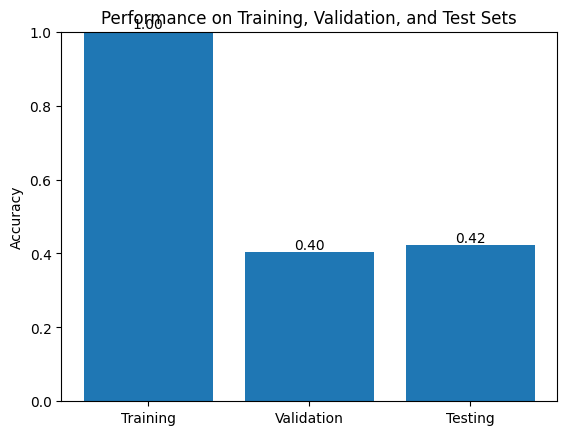

In [ ]:
#Visualization Performance of train performance

# Define the accuracy scores
train_accuracy = grid_search.score(x_train_pca, y_train)
val_accuracy = grid_search.score(x_val_pca, y_val)
test_accuracy = grid_search.score(x_test_pca, y_test)

# Create a list of set names and corresponding accuracy scores
set_names = ['Training', 'Validation', 'Testing']
accuracy_scores = [train_accuracy, val_accuracy, test_accuracy]

# Plot the histogram
plt.bar(set_names, accuracy_scores)
plt.title('Performance on Training, Validation, and Test Sets')
plt.xlabel('')
plt.ylabel('Accuracy')
plt.ylim([0, 1])

# Annotate the bars with accuracy values
for i, score in enumerate(accuracy_scores):
    plt.text(i, score, f'{score:.2f}', ha='center', va='bottom')

plt.show()

# Plot the confusion matrix

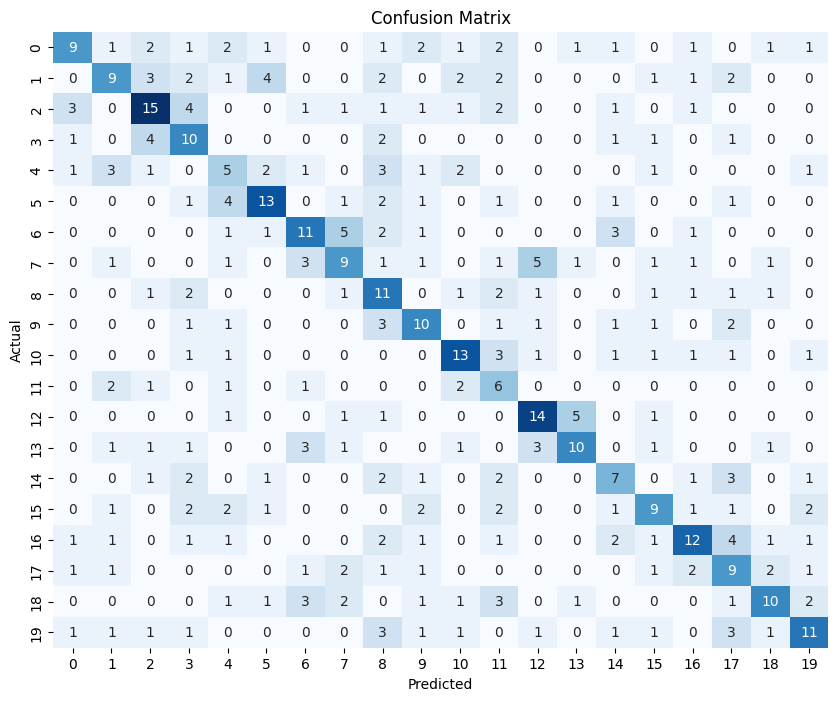

In [ ]:
# Confusion Matrix Generator
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()